# Tensorflow Tutorial \#1: Logistic Regression

Two years ago when deep learning had just come into sight, everybody was talking about which was better between *theano* and *tensorflow*. Now *tensorflow* has dominated this field, yet still it might be confused for beginners like me while learning *tensorflow*. Many tutorials seem to put too much attention on general ideas towards machine learning, and ignore some details. I found the original tutorial at [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/). Also along with my learning PRML, I would like to add some interesting points into this tutorial.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Now let's see some details of the dataset.

In [3]:
print("# test data:\t{}".format(data.test.num_examples))
print("# label format:\t{}".format(data.test.labels.shape))
print("# label example:\t{}".format(data.test.labels[0]))
print("# image data format:\t{}".format(data.test.images.shape))

# test data:	10000
# label format:	(10000, 10)
# label example:	[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
# image data format:	(10000, 784)


Before diving into tensorflow codes, implement a helper function to visualize images.

In [4]:
def plot_images(images, true_classes, pred_classes=None):
    '''Plot 3*3 images titling with their corresponding classes and predictions.
    
    '''
    assert len(images)==len(true_classes)==9
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape((28,28)), cmap="binary")
        
        # Show true classes & predictions
        if pred_classes:
            x_label = "True: {0}, Pred: {1}".format(true_classes[i], pred_classes[i])
        else:
            x_label = "True: {0}".format(true_classes[i])
        
        ax.set_xlabel(x_label)
        
        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])

Now it's time for tensorflow. In tensorflow, we first design a static calculation graph, then run training steps in a session. In a graph, we set **tf.Variable** (for parameters we wanna get) and **tf.placeholder** (for data points).

Let's first apply a linear algorithm to help us classify different images. Here, we use **softmax**. In theory, logistic regression follows a Bernulli distribution. If we approximate the probility *p* using a sigmod function, we get the format of a logistic regression. It's called a linear function because of the linear combination of a set of observed values.

We could design the type & shape for **tf.placeholder** variables. The shape [**None**, 10] means the variable could hold an arbitrary number of vectors of length 10. 

In [5]:
class LR:
    def __init__(self, w, b, max_iter=50, batch_size=100, step_length=0.1, C=0.1, penalty="l2"):
        '''Draw the calculation graph
        
        '''
        self.w = tf.Variable(w)
        self.b = tf.Variable(b)
        self.step_length = step_length
        assert w.shape[1]==b.shape[0]
        
        self.num_class = int(w.shape[1])
        
        self.C = C
        self.penalty = penalty
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.step_length = step_length
        
        # true values (input values)
        self.x = tf.placeholder(tf.float32, [None, w.shape[0]])
        self.y_vec = tf.placeholder(tf.int64, [None, b.shape[0]])
        
        # intermediate values
        self.y = tf.argmax(self.y_vec, dimension=1)
        
        self.logits = tf.matmul(self.x, self.w) + self.b
        self.y_pred_vec = tf.nn.softmax(self.logits)
        self.y_pred = tf.argmax(self.y_pred_vec, dimension=1)
        
        if self.penalty=="l2":
            self.cost = tf.reduce_sum(self.C * tf.square(self.w)) \
                + tf.reduce_sum(self.C * tf.square(self.b)) \
                + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y_vec))
        else:
            self.cost = tf.reduce_sum(self.C * tf.abs(self.w)) \
                + tf.reduce_sum(self.C * tf.abs(self.b)) \
                + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y_vec))
                                      
        self.optimizer = tf.train.GradientDescentOptimizer(self.step_length).minimize(self.cost)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.y, self.y_pred), tf.float32))
        self.sess = tf.Session()
        self.is_trained = False
        
        
    def train(self, data):
        '''Train the model with data provided.
        
        Return a list of accuracies for each iteration.
        '''
        accuracy_list = []
        self.sess.run(tf.global_variables_initializer())
        for epoch in range(self.max_iter):
            x_batch, y_batch = data.next_batch(self.batch_size)
            feed_dict={self.x:x_batch, self.y_vec:y_batch}
            self.sess.run(self.optimizer, feed_dict=feed_dict)
            acc = self.sess.run(self.accuracy, feed_dict=feed_dict)
            accuracy_list.append(acc)
            if (epoch+1)%10==0:
                print("# Epoch: {0}, Accuracy: {1: .1%}".format(epoch, acc))
        self.is_trained = True
        return accuracy_list
        
    def get_accuracy(self, x, y):
        if not self.is_trained:
            print("Model not trained. Please train it first.")
            return
        feed_dict = {self.y_vec:y, self.x:x}
        acc = self.sess.run(self.accuracy, feed_dict=feed_dict)
        print("Accuracy: {0: .1%}".format(acc))
        
    def plot_weights(self):
        '''After training, visualize weights.
        
        '''
        weights = self.sess.run(self.w)
        fig, axes = plt.subplots(int(self.num_class/4)+1,4)
        fig.subplots_adjust(hspace=0.6, wspace=0.3)
        for i,ax in enumerate(axes.flat):
            if i>=10: break
            ax.set_xlabel("W[{}]".format(i))
            ax.imshow(weights[:,i].reshape((28,28)), vmin=np.min(weights), vmax=np.max(weights), cmap="seismic")
        # remove ticks from all sub-plots
        ax.set_xticks([])
        ax.set_yticks([])
        
    def terminate(self):
        self.sess.close()

Now let's build up our first model, and initiate it with **zeros**.

# Epoch: 9, Accuracy:  82.0%
# Epoch: 19, Accuracy:  84.0%
# Epoch: 29, Accuracy:  78.0%
# Epoch: 39, Accuracy:  83.0%
# Epoch: 49, Accuracy:  81.0%
Accuracy:  82.8%


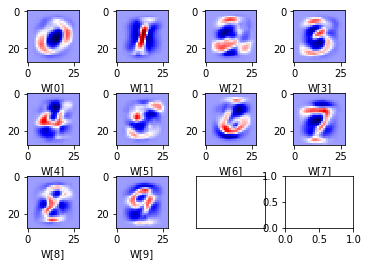

In [6]:
m1 = LR(tf.zeros([784,10]), tf.zeros(10))
acc_list = m1.train(data.train)
m1.plot_weights()
m1.get_accuracy(data.test.images, data.test.labels)
m1.terminate()

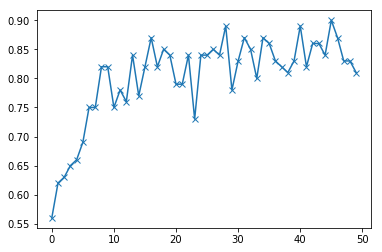

In [7]:
# show accuracies along training process
plt.plot(acc_list,'-x')
plt.show()

We have already know how to build up a *Logistic Regression* model, as well as how to train it and how to visualize it. However, it might be **misguiding** if we stop here. There are 2 shortages for us in this model:

* Initiate all the weights with zeros
We know *Neural Networks* could be cnstructed as a lot of sigmod layers, so could we initiate all the weights for a *Neural Network* too, just as what we do for a single layer of sigmod function (*Logistic Regression*) ?

The answer is absolutely **NOT**. If all the weights are zeros at first, when we update weights after the first iteration, what we actually do is to **w:=&Delta;w**. Because all the weights are the same, &Delta; would also be the same, leaves us a network with the same weights. No matter how many training iterations we have, we got each layer with the same weight values, which would dramatically harm the performance of the network.

In practice, we initiate weights with a **small random** number. Typically N(0,1) * 0.01.

* Using a softmax function is **NOT recommendable** for a *Neural Network*

The slope of a softmax is very sharp close to 0, while extremely flat when the input value becomes large. This means the **learning speed** would drop dramatically, so we should take more time waiting for its learning process. 

In practice, we should use **ReLU** function instead for *Neural Networks*, which slope is always 1 when input is positive.

Now let's initiate our *Logistic Regression* model with small random weights.

# Epoch: 9, Accuracy:  79.0%
# Epoch: 19, Accuracy:  84.0%
# Epoch: 29, Accuracy:  81.0%
# Epoch: 39, Accuracy:  87.0%
# Epoch: 49, Accuracy:  77.0%
Accuracy:  83.7%


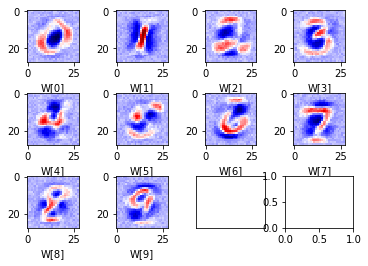

In [8]:
m2 = LR(0.01*tf.truncated_normal(shape=(784,10), mean=0.0, stddev=1.0, dtype=tf.float32), tf.zeros(10))
acc_list_random = m2.train(data.train)
m2.plot_weights()
m2.get_accuracy(data.test.images, data.test.labels)
m2.terminate()

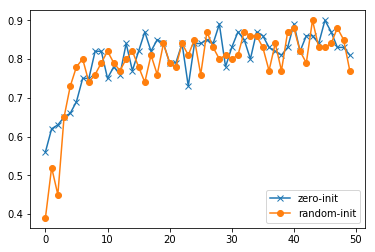

In [9]:
# show accuracies along training process
l1 = plt.plot(acc_list,'-x')
l2 = plt.plot(acc_list_random,'-o')
plt.legend(["zero-init", "random-init"])
plt.show()

We could see that for *LR*, **zero-init** enjoys a better result than **random init**